In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import numpy as np
import pickle,itertools
import shap
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,7)

import pickle

import warnings
warnings.filterwarnings('ignore')


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Features Selection

In [2]:
train_set = pd.read_csv('../data/train_df_expanded_KNN_imp_feats.csv')
train_set = train_set.replace([np.inf, -np.inf], np.nan)

y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target', 'Abs Target','Target > 2'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.45, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.66, shuffle=False)
X_val_2, X_test, y_val_2, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

X_val = X_val.iloc[5:]
y_val = y_val.iloc[5:]

X_train.columns=train_set.drop(['Date', 'Target', 'Abs Target','Target > 2'], axis=1).columns
X_val.columns=X_train.columns
X_test.columns=X_train.columns

In [3]:
params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['rmse'],
          'lambda': 1, 'max_depth': 4, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2, 'base_score': 0}

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

reg = xgb.train(params,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=180,verbose_eval=True,early_stopping_rounds=10)

[0]	train-rmse:3.65635	test-rmse:3.55624
[1]	train-rmse:3.54587	test-rmse:3.43963
[2]	train-rmse:3.43152	test-rmse:3.32032
[3]	train-rmse:3.32558	test-rmse:3.21159
[4]	train-rmse:3.22788	test-rmse:3.09826
[5]	train-rmse:3.14255	test-rmse:3.01027
[6]	train-rmse:3.05805	test-rmse:2.91663
[7]	train-rmse:2.97713	test-rmse:2.83103
[8]	train-rmse:2.89744	test-rmse:2.75199
[9]	train-rmse:2.82164	test-rmse:2.67790
[10]	train-rmse:2.75223	test-rmse:2.60150
[11]	train-rmse:2.68687	test-rmse:2.52843
[12]	train-rmse:2.62675	test-rmse:2.45623
[13]	train-rmse:2.56896	test-rmse:2.40218
[14]	train-rmse:2.51642	test-rmse:2.33982
[15]	train-rmse:2.46474	test-rmse:2.29994
[16]	train-rmse:2.41648	test-rmse:2.26519
[17]	train-rmse:2.37033	test-rmse:2.21953
[18]	train-rmse:2.32504	test-rmse:2.19034
[19]	train-rmse:2.28358	test-rmse:2.13949
[20]	train-rmse:2.23952	test-rmse:2.09818
[21]	train-rmse:2.20158	test-rmse:2.07148
[22]	train-rmse:2.16328	test-rmse:2.02479
[23]	train-rmse:2.13648	test-rmse:1.99017
[2

In [4]:
y_pred_train = reg.predict(dtrain)
y_pred_val = reg.predict(dval)

feat_importance = reg.get_score(importance_type='gain')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_gain = list(feat_importance.keys())[:10]

feat_importance = reg.get_score(importance_type='weight')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_weight = list(feat_importance.keys())[:10]

explainer = shap.TreeExplainer(reg)
shap_values = explainer(X_train)
shap_summary = pd.DataFrame(shap_values.values, columns=X_train.columns)
mean_abs_shap_values = shap_summary.abs().mean().sort_values(ascending=False)
top_10_shap = mean_abs_shap_values.head(10).index.tolist()

top_K_feat = list(set(top_10_gain+top_10_weight+top_10_shap))

In [5]:
with open("./sandbox_output/top_K_feat_from_3k_reg_all_classes.pkl", "wb") as f:
    pickle.dump(top_K_feat, f)

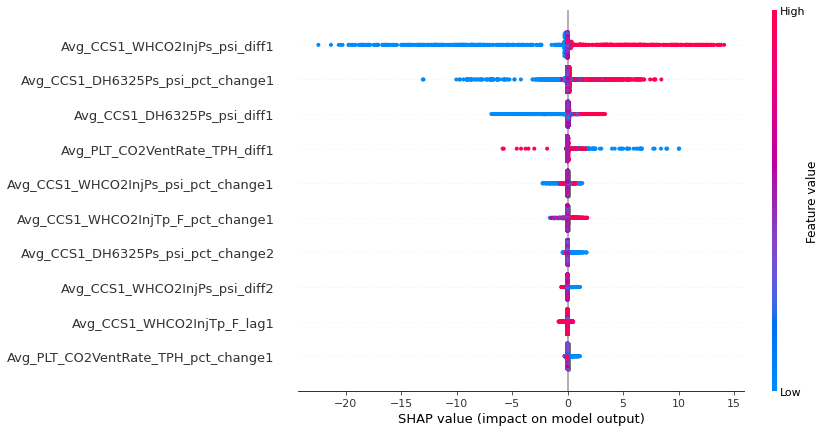

In [6]:
shap.summary_plot(shap_values, X_train,
                   plot_size=(10, 7), max_display=10)

## Hyperparameters tunning

In [7]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target', 'Abs Target','Target > 2'], axis=1)
x_train = x_train[list(top_K_feat) ]

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

X_val = X_val.iloc[5:]
y_val= y_val.iloc[5:]

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

In [8]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'tree_method': ['exact'],
    'nthread': [-2],
    'eta': [0.05],
    'max_depth': [4], 
    'objective': ['reg:squarederror'],
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]


In [9]:
y_test2=y_val
y_test2.reset_index(drop=True,inplace=True)

# Initialize empty lists to store results
rmse_scores=[]
MAPE_scores=[]
hyparparams_list = []
num_trees_list = []

for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    reg = xgb.train(hyperparams,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=1000,verbose_eval=False,early_stopping_rounds=5)

    # Make predictions on the test set
    y_pred_train = reg.predict(dtrain)
    y_pred_val = reg.predict(dval)

    num_trees = reg.best_ntree_limit
    num_trees_list.append(num_trees)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    print('RMSE: {:.2f}'.format(rmse))
    rmse_scores.append(rmse)
    
    MAPE=mean_absolute_percentage_error(y_test2, y_pred_val, sample_weight=np.abs(y_test2)/sum(np.abs(y_test2)))
    print('MAPE: {:.2f}%'.format(MAPE))
    MAPE_scores.append(MAPE)

# Combine the results into a list of dictionaries
results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    results.append({
        'hyperparameters': hyperparams,
        'RMSE': rmse_scores[i],
        'MAPE': MAPE_scores[i],
    })

RMSE: 1.66
MAPE: 0.56%
RMSE: 1.86
MAPE: 0.63%
RMSE: 1.78
MAPE: 0.62%
RMSE: 1.77
MAPE: 0.59%
RMSE: 1.72
MAPE: 0.59%
RMSE: 1.79
MAPE: 0.60%
RMSE: 1.76
MAPE: 0.60%
RMSE: 1.75
MAPE: 0.56%
RMSE: 1.61
MAPE: 0.54%
RMSE: 1.74
MAPE: 0.61%
RMSE: 1.66
MAPE: 0.55%
RMSE: 1.92
MAPE: 0.67%
RMSE: 1.64
MAPE: 0.55%
RMSE: 1.65
MAPE: 0.55%
RMSE: 1.63
MAPE: 0.56%
RMSE: 1.72
MAPE: 0.56%
RMSE: 1.64
MAPE: 0.56%
RMSE: 1.79
MAPE: 0.60%
RMSE: 1.81
MAPE: 0.62%
RMSE: 1.76
MAPE: 0.59%
RMSE: 1.71
MAPE: 0.59%
RMSE: 1.73
MAPE: 0.58%
RMSE: 1.73
MAPE: 0.59%
RMSE: 1.73
MAPE: 0.55%
RMSE: 1.58
MAPE: 0.52%
RMSE: 1.69
MAPE: 0.58%
RMSE: 1.70
MAPE: 0.57%
RMSE: 1.75
MAPE: 0.60%
RMSE: 1.63
MAPE: 0.55%
RMSE: 1.66
MAPE: 0.57%
RMSE: 1.70
MAPE: 0.58%
RMSE: 1.67
MAPE: 0.55%


In [10]:
# Find the best hyperparameters based on the lowest RMSE
best_idx = np.argmin([x['RMSE'] for x in results])

# Get the best threshold, hyperparameters, and optimal number of trees
best_hyperparams = results[best_idx]['hyperparameters']
opt_num_trees = num_trees_list[best_idx]

print(results[best_idx])
print(f'Num of trees: {opt_num_trees}')

{'hyperparameters': {'alpha': 5, 'lambda': 5, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror'}, 'RMSE': 1.5826803918119414, 'MAPE': 0.524735058664365}
Num of trees: 127


## Testing results on validation set

In [20]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Target > 2', 'Abs Target'], axis=1)
    
x_train = x_train[list(top_K_feat) ]

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

X_train.columns=x_train.columns
X_test.columns=x_train.columns

X_test = X_test.iloc[5:]
y_test = y_test.iloc[5:]
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_test, y_test)
reg= xgb.train(best_hyperparams,dtrain,num_boost_round=int(opt_num_trees*1.09))
preds_reg=reg.predict(dval)
rmse = np.sqrt(mean_squared_error( y_test, preds_reg))
rmse

1.445850835000955

In [21]:
reg.save_model('./sandbox_output/reg_all_classes_val.json')

In [14]:
X_test['Target']=y_test
X_test['Prediction']=preds_reg

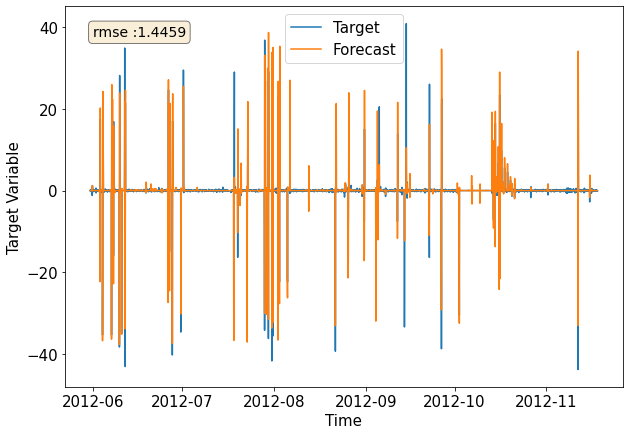

In [17]:
train_set['Date']=pd.to_datetime(train_set['Date'])
# plot the forecasted values against the real values
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Target'], label='Target')
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Prediction'], label='Forecast')
textstr = 'rmse :' + str(rmse.round(4)) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.rcParams.update({'font.size': 15})
plt.legend()
plt.show()

## Preparing model for testing set

In [16]:

y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target', 'Abs Target','Target > 2'], axis=1)
x_train = x_train[list(top_K_feat) ]

dtrain = xgb.DMatrix(x_train, y_train)
reg= xgb.train(best_hyperparams,dtrain,num_boost_round=int(opt_num_trees*1.09))

reg.save_model('./sandbox_output/Reg_all_classes.json')